In [70]:
%reload_ext autoreload
%autoreload 2

In [1]:
import os

os.chdir("../../../test_data/system_tests/proteoforms/cluster_tests")

In [36]:
INPUT_FILE = "100ng_subset.tsv.spectronaut_fragion_isotopes.aq_reformat.tsv"
SAMPLEMAP = "samplemap_egfr_100ng.tsv"

CONDPAIR = ('untreated', 'egf_treated')
RESULTS_DIR = "results_minrep5"

In [10]:
import alphaquant.diffquant_utils as aqutils
condpairtree_proteome = aqutils.read_condpair_tree(cond1=CONDPAIR[0][0], cond2=CONDPAIR[0][1], results_folder=RESULTS_DIR)
protein_nodes = condpairtree_proteome.children


In [18]:
print(protein_nodes[0].children[0])

AnyNode(cluster=2, clustscore=12.0, cv=0.0632756339201486, fc=-0.47051987004925033, frac_mainclust=0.5, fraction_consistent=0.5, is_included=True, min_intensity=6314086.8693295205, min_reps=5.0, name='SEQ_ISMPDVDLHLK_', num_clusters=2, num_mainclusts=1, p_val=0.08290358976749701, type='seq', z_val=-1.7340816901643283)


In [177]:
import alphaquant.cluster_ions as aqclust
import alphaquant.benchmarking as aqbench
import numpy as np

diffions_real, normed_c1_real, normed_c2_real = aqbench.load_real_example_ions(input_file=INPUT_FILE,
samplemap_file=SAMPLEMAP,num_ions=np.inf, condpair = CONDPAIR, minrep = 5)
print(diffions_real)
type_node = protein_nodes[6]
name2diffion = {x.name : x for x in diffions_real}

def get_grouped_diffions_for_node(type_node, name2diffion):
    grouped_diffions = []
    for child in type_node.children:
        all_diffion_names_for_child = [x.name for x in child.leaves]
        diffions_for_child = [name2diffion.get(x) for x in all_diffion_names_for_child]
        grouped_diffions.append(diffions_for_child)
    return grouped_diffions

diffions_grouped = get_grouped_diffions_for_node(type_node, name2diffion)
print(len(diffions_grouped))


('untreated', 'egf_treated')
t_ion2nonan_sw 0.007946014404296875
t_intensity_selection 0.23622512817382812
t_ion2nonan_sw 0.00923919677734375
t_intensity_selection 0.255169153213501
[<alphaquant.diff_analysis.DifferentialIon object at 0x7fa4f8f64580>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa56d3f7ca0>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa5181bbb80>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa5181bb910>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa5181bb640>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa55bd8a580>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa55bd8a130>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa55bd8adc0>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa56f28a4f0>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa4f9786d00>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa4f9e37f10>, <alphaquant.diff_analysis.DifferentialIon object at 0x7fa4

In [178]:
import alphaquant.visualizations as aqvis
quantification_info = aqvis.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS_DIR, samplemap=SAMPLEMAP)
pepdf_getter = aqvis.PeptideIntensityDataframeGetter(quantification_info=quantification_info)

In [179]:
ion2diffDist = {}
p2z = {}
deedpair2doublediffdist = {}

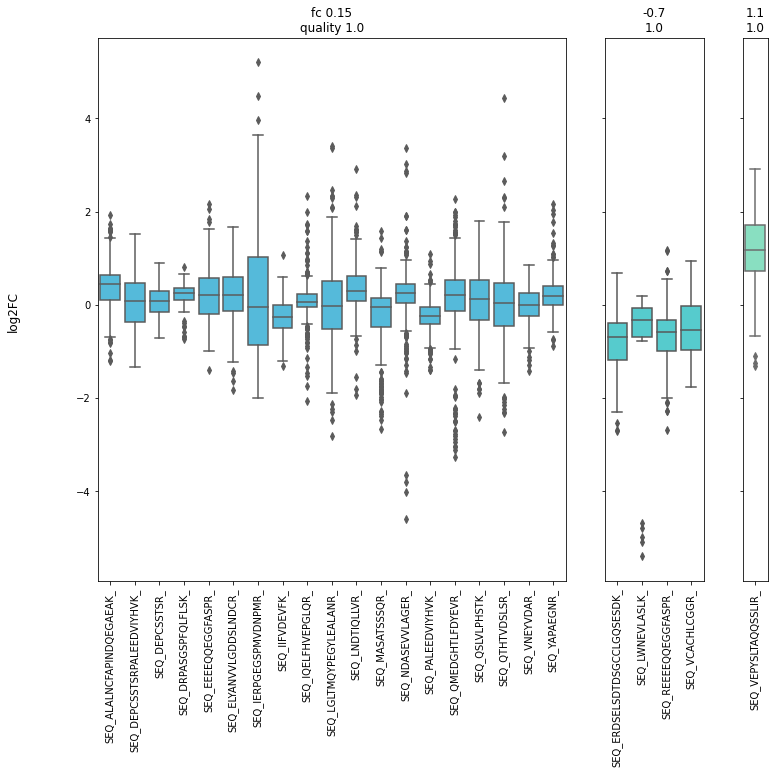

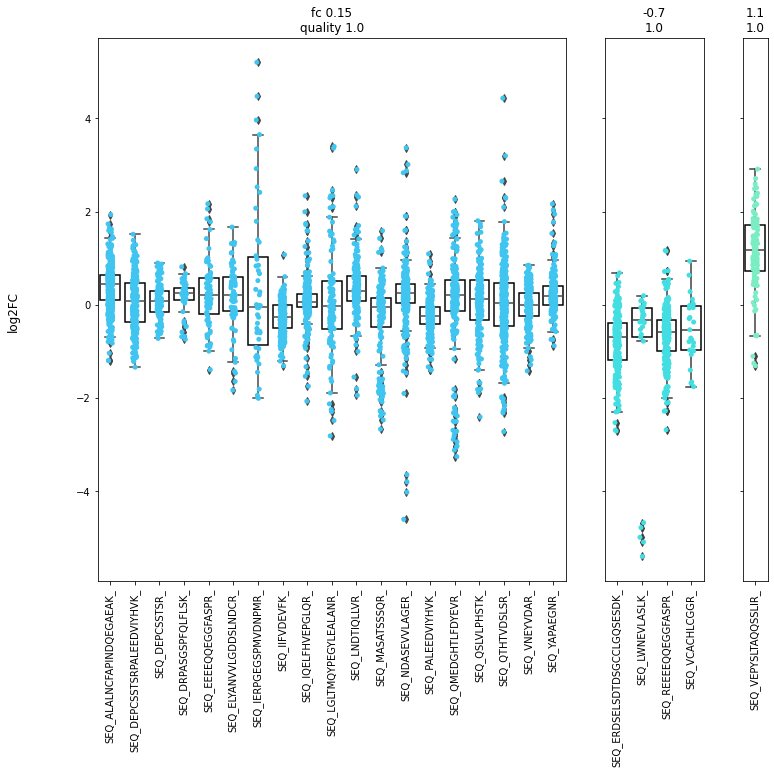

In [184]:
import matplotlib.pyplot as plt

import numpy as np

import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy
from collections import defaultdict

def merge_similar_clusters(childnode2clust, typenode, fc_cutoff):
    clust2childnodes = invert_tuple_list_w_nonunique_values(childnode2clust)
    clust2fc = {}
    for clust, childnodes in clust2childnodes.items():
        clust2fc[clust] = np.median([x.fc for x in childnodes])

    clusters = list(clust2fc.keys())
    clust_idxs = [[x] for x in range(len(clust2fc.keys()))]

    condensed_distance_matrix = distance.pdist(clust_idxs, lambda idx1, idx2: compare_fcdistance(clusters, idx1, idx2, clust2fc, fc_cutoff))
    after_clust = hierarchy.complete(condensed_distance_matrix)
    clustered = hierarchy.fcluster(after_clust, 0.1, criterion='distance')

    typenode.num_clusters = len(set(clustered))
    typenode.num_mainclusts = sum([x==0 for x in clustered])
    typenode.frac_mainclust = typenode.num_mainclusts/len(clustered)

    childnode2clust = update_childnode2clust(childnode2clust, clusters, clustered)

    return childnode2clust


def invert_tuple_list_w_nonunique_values(d):
    inverted_dict = defaultdict(list)
    for key, value in d:
        inverted_dict[value].append(key)
    return inverted_dict

def compare_fcdistance(clusters, idx1, idx2, clust2fc,fc_cutoff):
    clust1 = clusters[idx1[0]]
    clust2 = clusters[idx2[0]]

    fc1 = clust2fc.get(clust1)
    fc2 = clust2fc.get(clust2)

    if abs(fc1-fc2) < fc_cutoff:
        return 0
    else:
        return 1


def update_childnode2clust(childnode2clust, old_clusters, new_clusters):
    old2new = dict(zip(old_clusters, new_clusters))
    childnode2clust_new = []
    for childnode, old_clust in childnode2clust:
        new_clust = old2new[old_clust]
        childnode2clust_new.append((childnode, new_clust))
    return childnode2clust_new
    


childnode2clust = aqclust.find_fold_change_clusters(type_node, diffions_grouped, normed_c1_real, normed_c2_real, ion2diffDist, p2z, deedpair2doublediffdist, 
pval_threshold_basis = 0.2, fcfc_threshold=0, take_median_ion = False) #the clustering is performed on the child nodes
childnode2clust = merge_similar_clusters(childnode2clust, type_node, fc_cutoff = 0.5)
childnode2clust = aqclust.decide_cluster_order(type_node,childnode2clust)
aqclust.annotate_mainclust_leaves(childnode2clust)
aqclust.assign_cluster_number(type_node, childnode2clust)
aqclust.assign_vals_to_node(type_node,only_use_mainclust=True, use_fewpeps_per_protein=True)

pcplotter = aqvis.ProteinClusterPlotter(type_node,CONDPAIR, pepdf_getter, level = 'seq', add_stripplot = False)
pcplotter.plot_all_clusters_for_protein()
plt.show()
pcplotter = aqvis.ProteinClusterPlotter(type_node,CONDPAIR, pepdf_getter, level = 'seq', add_stripplot = True)
pcplotter.plot_all_clusters_for_protein()
plt.show()

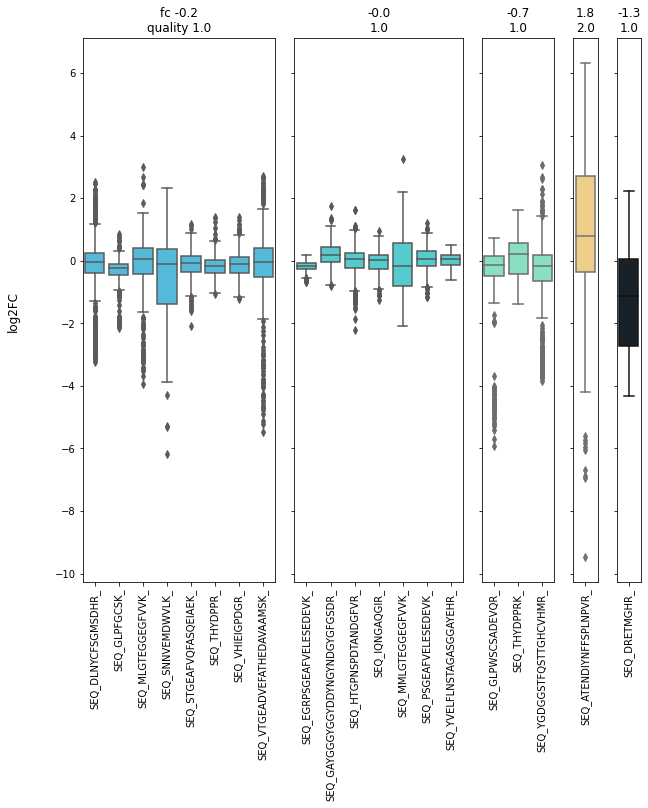

In [ ]:
import pandas as pd
import alphaquant.diff_analysis_manager as diffmgr

diffmgr.run_pipeline(input_file=INPUT_FILE, samplemap_file=SAMPLEMAP, results_dir=RESULTS_DIR, condpair_combinations=CONDPAIR, 
                        take_median_ion=False,minrep=5, runtime_plots=True, use_ml = False)